In [1]:
import scanpy
import scprep
import phate
import numpy as np
import graphtools
import seaborn as sns
import pandas as pd

In [2]:
scanpy.set_figure_params(dpi_save=300)

In [37]:
adata = scanpy.read_h5ad('data/all_exocrine_endocrine_processed.h5ad')

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [40]:
marker_list = {
    "beta": ["Ins1", "Ins2"],
    "delta": ["Sst"],
    "γ (PP)":["Ppy"],
    "alpha":["Gcg"],
    "ductal": ["Sox9", "Hnf1b", "Muc1", "Krt19"],
    "endothelial": ['Pecam1', 'Plvap'],
    "acinar": ['Cpa1', 'Prss2'],
    "immune": ['Cd52', 'Ptprc'],
    'stellate-activated': ['Col1a2', 'Bicc1', 'Pdgfra'],
    'stellate-quiescent': ['Ndufa4l2', 'Acta2', 'Cspg4', 'Rgs5'],
    "epsilon": ['Ghrl'],
    'Schwann': ['Cryab', 'Plp1']
}

In [41]:
def darken_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [42]:
gene_subset_only = ["Ins1", 'Ins2', 'Sst', 'Ppy', 'Gcg']
phate_op = phate.PHATE(random_state=42, verbose=True)
adata.obsm['X_phate'] = phate_op.fit_transform(adata[:, ~adata.var['names'].isin(gene_subset_only)].to_df())

clustering = phate.cluster.kmeans(phate_op, n_clusters=20, random_state=42)
adata.obs['clusters'] = pd.Series(clustering, index=adata.obs_names).astype('category')
cmap = [darken_color(x, amount=1.1) for x in sns.color_palette('tab10', n_colors=10)] + \
[darken_color(x) for x in sns.color_palette('tab10', n_colors=10)]

Calculating PHATE...
  Running PHATE on 23469 observations and 16478 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.17 seconds.
    Calculating KNN search...
    Calculated KNN search in 70.83 seconds.
    Calculating affinities...
    Calculated affinities in 10.19 seconds.
  Calculated graph and diffusion operator in 89.76 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.57 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.15 seconds.
  Calculated landmark operator in 6.17 seconds.
  Calculating optimal t...
    Automatically selected t = 42
  Calculated optimal t in 1.23 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.83 seconds.
Calculated PHATE in 102.31 seconds.


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

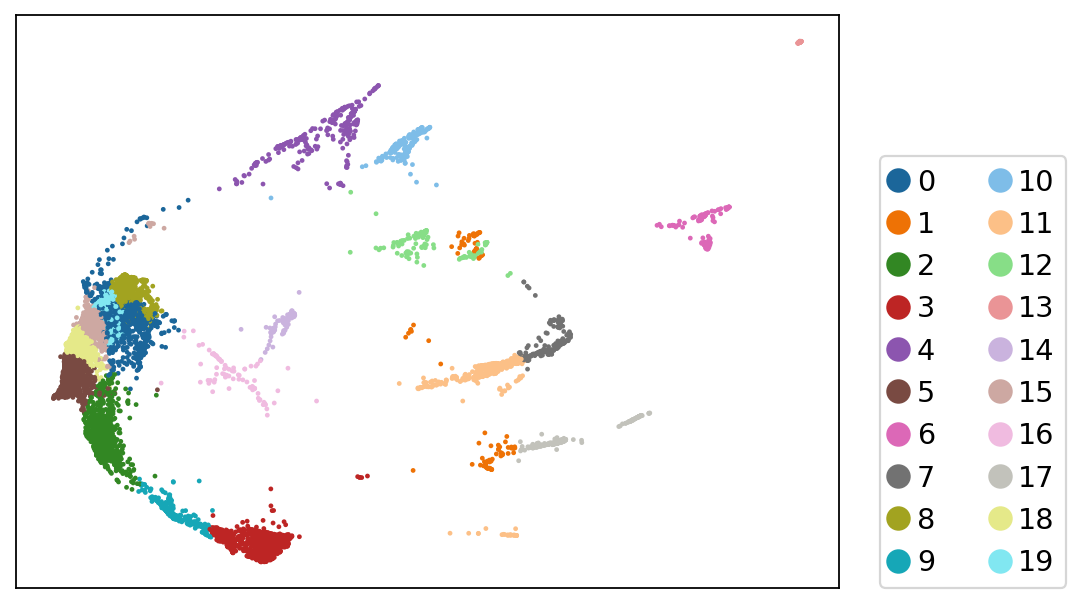

In [43]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['clusters'], legend_loc=(1.05, 0), ticks=None,
                      figsize=(7,4), cmap=cmap, filename='figures/endocrine_exocrine_cells_clusters.png', dpi=300)

In [44]:
adata.var["mt"] = adata.var['names'].str.startswith("mt-")
scanpy.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

/tmp/ipykernel_2746465/512320218.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=adata.obs, x=adata.obs['clusters'], y=adata.obs['log1p_n_genes_by_counts'], palette=cmap)


<Axes: xlabel='clusters', ylabel='log1p_n_genes_by_counts'>

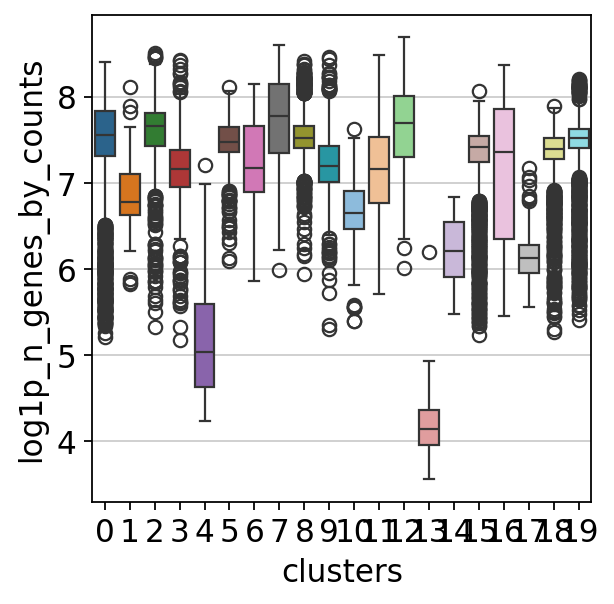

In [45]:
sns.boxplot(data=adata.obs, x=adata.obs['clusters'], y=adata.obs['log1p_n_genes_by_counts'], palette=cmap)

In [46]:
adata.obs['clusters'] = pd.Categorical(clustering, ordered=True, categories=[0, 5, 8, 15, 18, 19, 16, 2, 9, 3, 12, 7, 11, 4, 1, 10, 17, 6, 13, 14])

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


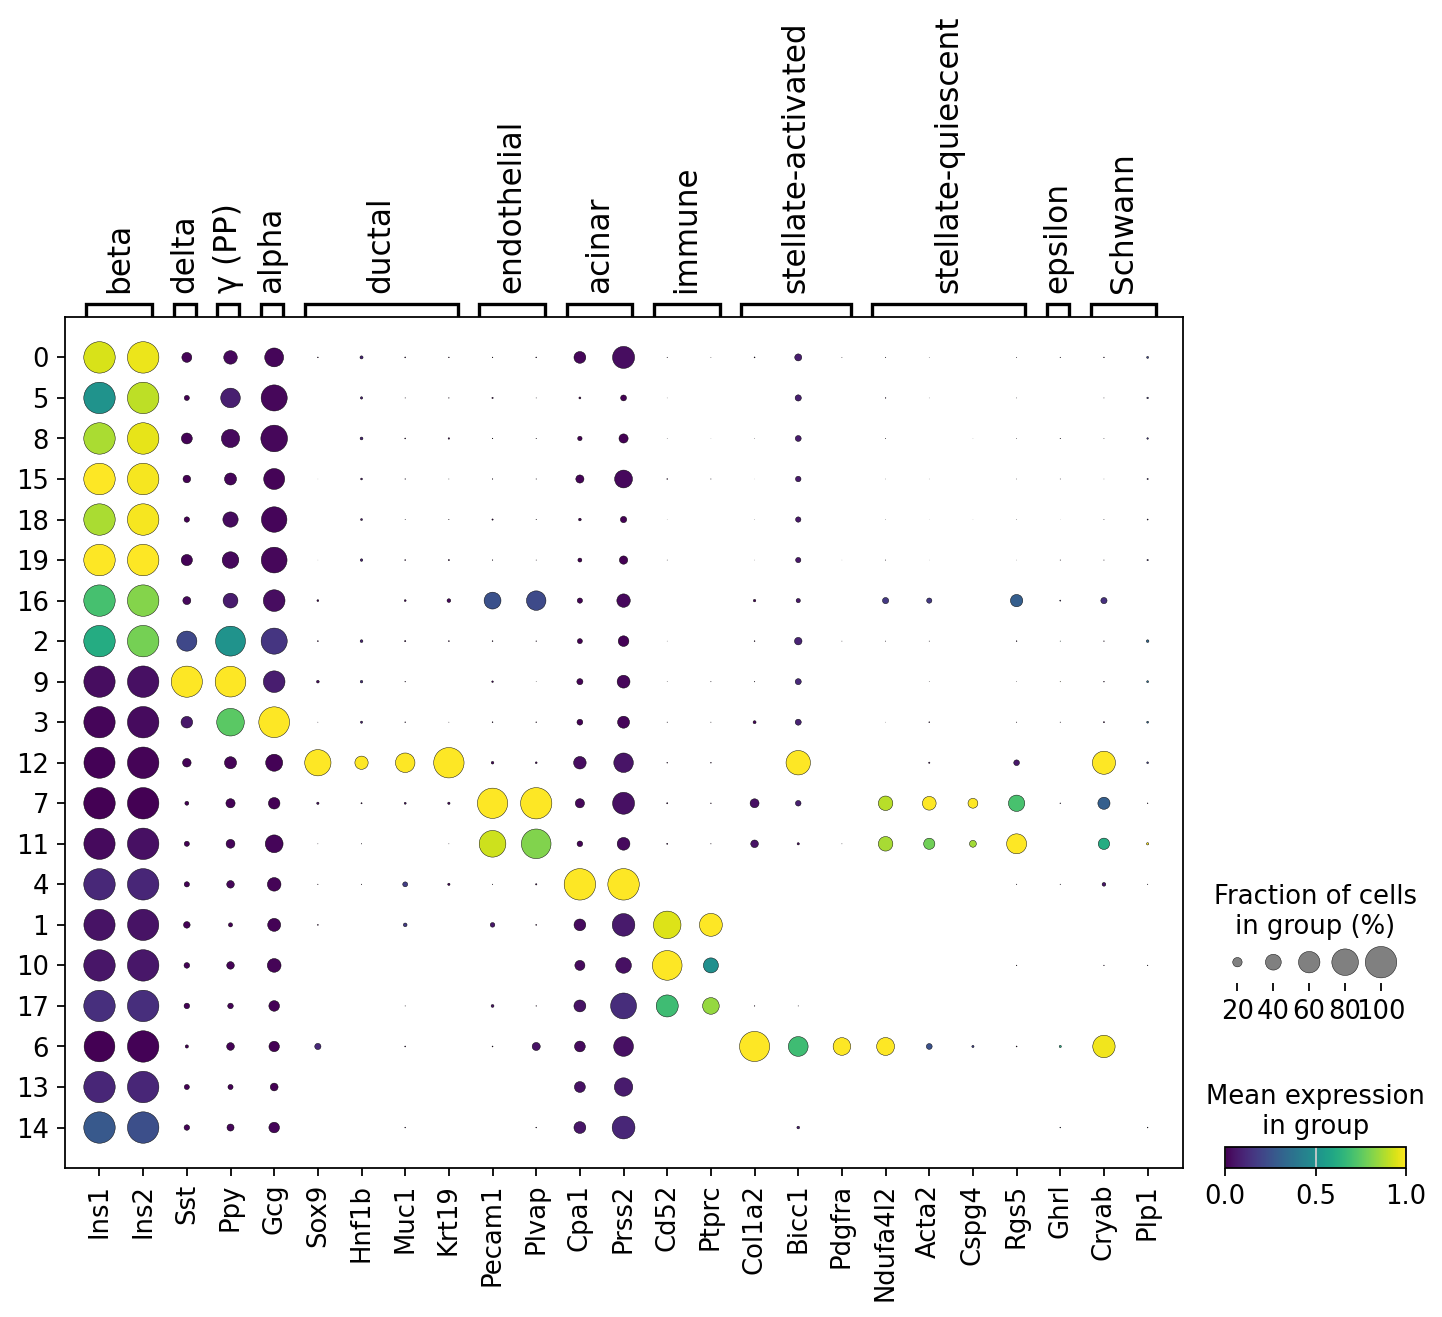

In [47]:
adata.var_names_make_unique()
scanpy.pl.dotplot(adata, groupby='clusters', var_names=marker_list, gene_symbols='names', standard_scale='var',
                     cmap='viridis', save='all_exocrine_endocrine.png')

In [48]:
endocrine_clusters = [0, 5, 8, 15, 18, 19, 16, 2, 9, 3]

In [49]:
adata.write('data/all_exocrine_endocrine_processed.h5ad', compression='gzip')